### 1.0 -Load libraries
In our Second Hand Car Price Prediction project we used SXBoost, mada score

In [230]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # library for visualization
import seaborn as sns # library for visualization
import warnings
import os
import csv 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

warnings.filterwarnings('ignore')
sns.set_palette('Spectral')
sns.set_context('notebook', font_scale=1)
sns.set_style('whitegrid')
# set pandas 3 digits decimal
pd.set_option('display.float_format', '{:.3f}'.format)

<p> Note to self: <br>
1- Load the initial data, clean car data that can cause false calculations. + <br>
2- Fill, complete missing values +<br>
3- Change all data into numerical values. <--- <br>
4- Try the ML algorithms: KNN, Kmean clustering, XGBoost... <br>
5- Start building the web app
</p>

<h4> 1.1 Load the available data </h4>

In [231]:
dir = 'Data_files/filled_data.csv'
with open(dir, mode='r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader, None)
    
# print first 5 recording of data
df=pd.read_csv(dir)
df.columns = df.columns.str.lower()  # Convert all column names to lowercase
print(df.head(3))
print()
print(df.columns)


   year manufacturer        model  condition  cylinders fuel  odometer  \
0 0.009         ford       deluxe  excellent          6  gas     0.002   
1 0.009    chevrolet  3100 truck'       good          6  gas     0.003   
2 0.009         ford        sedan       good          8  gas     0.005   

  title_status transmission drive       size   type paint_color  price  
0        clean       manual   rwd  full-size  sedan       black   9500  
1        clean       manual   rwd  full-size  truck       green  16000  
2        clean       manual   fwd   mid-size  sedan       green  18000  

Index(['year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'size', 'type',
       'paint_color', 'price'],
      dtype='object')


#### 1.2 APPEND data from internet and append the data to available data

This is done to increase amount of data and to increase coherence.

In [232]:
"""
# ATTRIBUTES ARE:
#['year','manufacturer','model','condition','cylinders','fuel','odometer','title_status','transmission','drive','size','type','paint_color','price']
dir = 'car_data2.csv'
with open(dir, mode='r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader, None)
    
# print first 5 recording of data
df=pd.read_csv(dir)
df.columns = df.columns.str.lower()  # Convert all column names to lowercase
print(df.head(3))
print()
print(df.columns)
"""

"\n# ATTRIBUTES ARE:\n#['year','manufacturer','model','condition','cylinders','fuel','odometer','title_status','transmission','drive','size','type','paint_color','price']\ndir = 'car_data2.csv'\nwith open(dir, mode='r') as file:\n    csv_reader = csv.reader(file)\n    next(csv_reader, None)\n    \n# print first 5 recording of data\ndf=pd.read_csv(dir)\ndf.columns = df.columns.str.lower()  # Convert all column names to lowercase\nprint(df.head(3))\nprint()\nprint(df.columns)\n"

### Conversion of categorical data into numerical data

In [233]:
# Columns to encode
columns_to_encode = ['manufacturer', 'model', 'condition','cylinders', 'fuel', 'title_status','transmission', 'size', 'type','paint_color']

# One-hot encode the specified columns
df_encoded = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)
# Display the transformed DataFrame
print(df_encoded.head(3))



   year  odometer drive  price  manufacturer_alfa-romeo  \
0 0.009     0.002   rwd   9500                    False   
1 0.009     0.003   rwd  16000                    False   
2 0.009     0.005   fwd  18000                    False   

   manufacturer_aston-martin  manufacturer_audi  manufacturer_bmw  \
0                      False              False             False   
1                      False              False             False   
2                      False              False             False   

   manufacturer_buick  manufacturer_cadillac  ...  paint_color_brown  \
0               False                  False  ...              False   
1               False                  False  ...              False   
2               False                  False  ...              False   

   paint_color_custom  paint_color_green  paint_color_grey  \
0               False              False             False   
1               False               True             False   
2          

## HANDLING MISSING VALUES

Skewness: 39.197325787865374


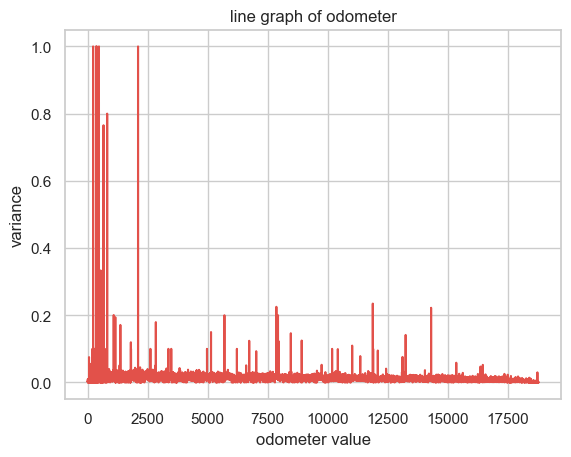

year        -2.452
cylinders    0.160
odometer    39.197
price        2.333
dtype: float64


In [234]:
skewness = df['odometer'].skew()
print(f"Skewness: {skewness}")
df['odometer'].plot(kind='line')
plt.title('line graph of odometer')
plt.xlabel('odometer value')
plt.ylabel('variance')
plt.show()
df['odometer'] = df['odometer'].fillna(df['odometer'].median()) # HANDLING FOR SKEWED DATA
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
print(df[numerical_cols].skew())

df['year'] = df['year'].fillna(df['year'].mean()) # HANDLING FOR SYMMETRIC DATA

<h4> FILLING MISSING VALUES FOR CATEGORICAL DATA </h4>

In [235]:
# Columns to handle
categorical_columns = ['manufacturer', 'model', 'condition', 'cylinders', 
                      'fuel', 'title_status', 'transmission', 'drive', 
                      'size', 'type', 'paint_color']
numerical_columns = ['year', 'odometer']  # Numerical columns

# Step 1: Replace "other" in categorical columns with the mode
for col in categorical_columns:
    mode_value = df[col].mode()[0]  # Find the mode
    df[col] = df[col].replace('other', mode_value)

# Step 2: Fill missing values in numerical columns with the median
for col in numerical_columns:
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)

# Step 3: Encode categorical columns for KNNImputer
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))

# Step 4: Apply KNNImputer for further imputation
imputer = KNNImputer(n_neighbors=5)
columns_to_impute = numerical_columns + categorical_columns
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

# Step 5: Decode categorical columns back to original labels
for col in categorical_columns:
    df[col] = label_encoders[col].inverse_transform(df[col].round().astype(int))

# Step 6: Save the processed DataFrame to a new CSV file
df.to_csv('FIXED_data.csv', index=False)
print("Processed data saved to 'FIXED_data.csv'.")

Processed data saved to 'FIXED_data.csv'.


### 3.0 Analyzing data

##### Converting all attributes into numerical values

In [236]:
# After loading the data, add this section for categorical to numerical conversion

# 1. Load the data
df = pd.read_csv('Data_files/filled_data.csv')

min_max_scaler = preprocessing.MinMaxScaler()
# Normalize odometer
df['odometer'] = min_max_scaler.fit_transform(df[['odometer']])

# 2. Define categorical columns
categorical_columns = [
    'manufacturer', 
    'model', 
    'condition',
    'cylinders', 
    'fuel', 
    'title_status',
    'transmission', 
    'drive', 
    'size', 
    'type',
    'paint_color'
]

# 3. Initialize dictionary to store label encoders
label_encoders = {}

# 4. Create a copy of the dataframe for encoding
df_encoded = df.copy()

# 5. Apply label encoding to each categorical column
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    df_encoded[column] = label_encoders[column].fit_transform(df_encoded[column].astype(str))

# 6. Save the encoded data to a new CSV file
df_encoded.to_csv('numerical_data.csv', index=False)

# 7. Print first few rows to verify the conversion
print("First few rows of the encoded data:")
print(df_encoded.head())

# 8. Print the mapping for each categorical column
for column in categorical_columns:
    print(f"\nMapping for {column}:")
    for i, label in enumerate(label_encoders[column].classes_):
        print(f"{label} -> {i}")

First few rows of the encoded data:
   year  manufacturer  model  condition  cylinders  fuel  odometer  \
0 0.009            13   1339          1          5     2     0.002   
1 0.009             7    187          3          5     2     0.003   
2 0.009            13   3403          3          6     2     0.005   
3 0.009             7   3705          1          6     2     0.001   
4 0.009             7   3705          0          6     2     0.001   

   title_status  transmission  drive  size  type  paint_color  price  
0             1             1      2     1     8            0   9500  
1             1             1      2     1     9            4  16000  
2             1             1      1     2     8            4  18000  
3             1             0      2     2     3           11  22000  
4             1             0      2     2     3           11  22000  

Mapping for manufacturer:
acura -> 0
alfa-romeo -> 1
aston-martin -> 2
audi -> 3
bmw -> 4
buick -> 5
cadillac -> 6
c

### 4.0 MACHINE LEARNING

#### K-means clustering

Cluster Analysis:

Cluster 0:
Number of cars: 4583
Average price: $13,293.70
Price range: $550.00 - $155,000.00

Cluster 1:
Number of cars: 4537
Average price: $13,341.93
Price range: $600.00 - $124,900.00

Cluster 2:
Number of cars: 1381
Average price: $12,508.08
Price range: $550.00 - $125,000.00

Cluster 3:
Number of cars: 4617
Average price: $15,147.61
Price range: $599.00 - $103,000.00

Cluster 4:
Number of cars: 3657
Average price: $15,123.24
Price range: $500.00 - $169,999.00


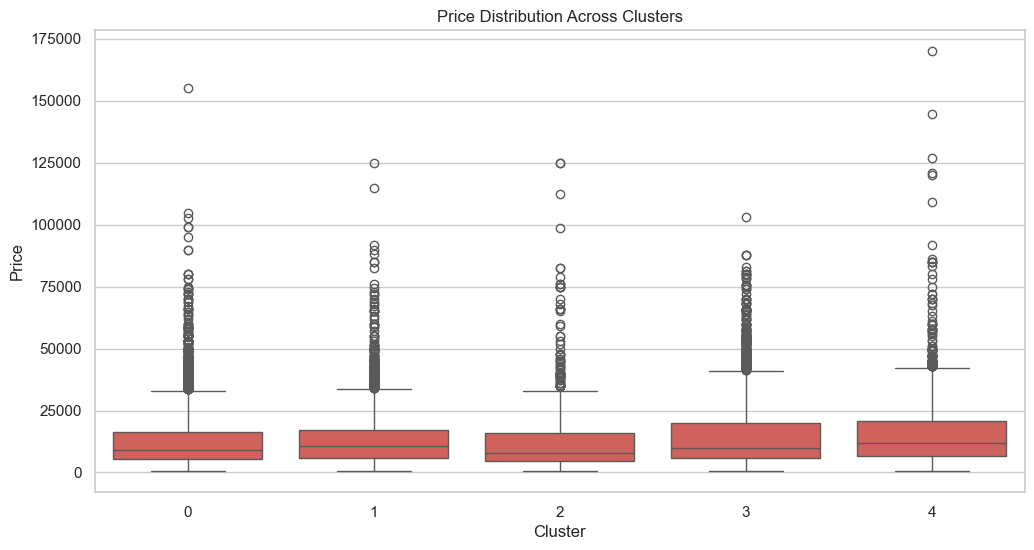

R² score for k=3: 0.5377
R² score for k=4: 0.5412
R² score for k=5: 0.5408
R² score for k=6: 0.5342
R² score for k=7: 0.5267
R² score for k=10: 0.5085


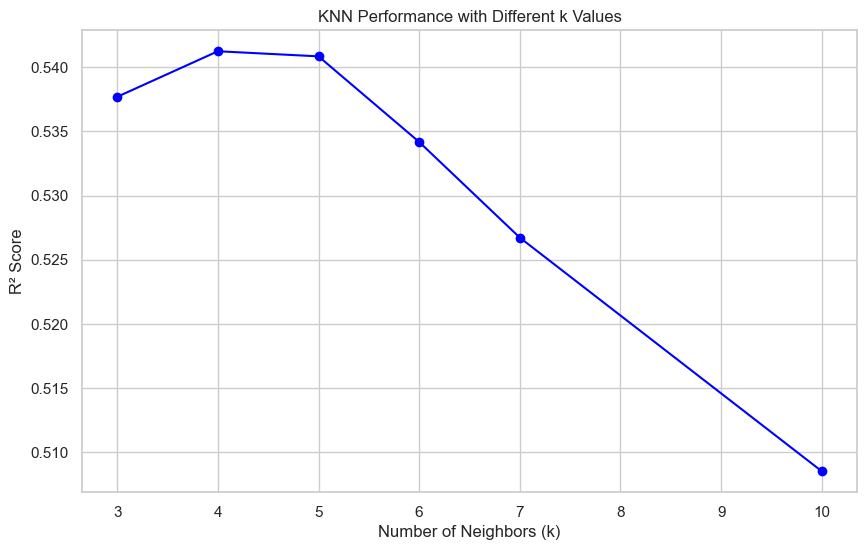


Best KNN Model (k=4):
R² Score: 0.5412
MAPE: 0.6519


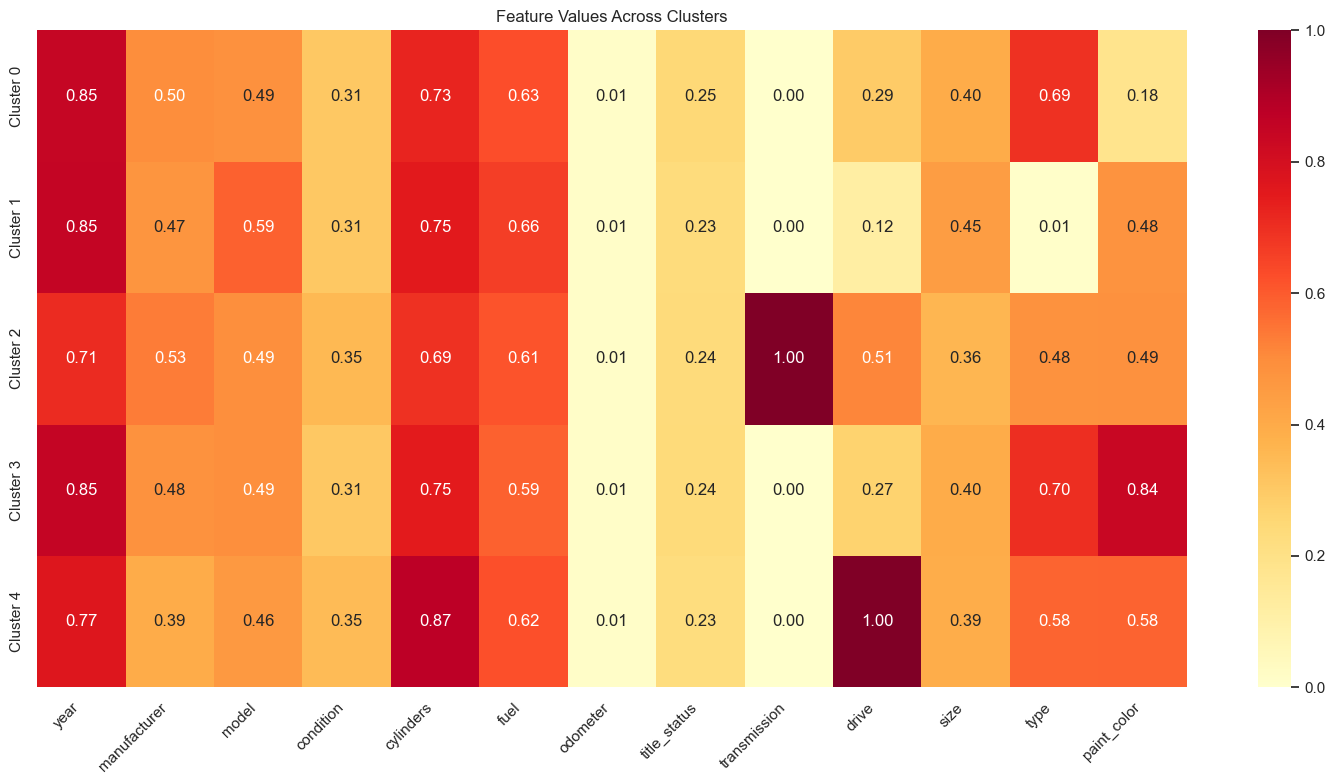


Average Price by Cluster (sorted):
Cluster
3   15147.613
4   15123.239
1   13341.926
0   13293.697
2   12508.080
Name: price, dtype: float64


In [237]:
# 1. Load and prepare the data
df = pd.read_csv('numerical_data.csv')

# 2. Separate features and target
X = df.drop('price', axis=1)
y = df['price']

# 3. Scale all features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 4. Apply K-means clustering
n_clusters = 5  # You can adjust this based on your needs
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original dataframe
df['Cluster'] = cluster_labels

# 5. Analyze clusters
print("Cluster Analysis:")
for cluster in range(n_clusters):
    cluster_data = df[df['Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"Number of cars: {len(cluster_data)}")
    print(f"Average price: ${cluster_data['price'].mean():,.2f}")
    print(f"Price range: ${cluster_data['price'].min():,.2f} - ${cluster_data['price'].max():,.2f}")

# 6. Visualize price distribution across clusters
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='price', data=df)
plt.title('Price Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Price')
plt.show()

# 7. Apply KNN regression to predict prices based on clusters and features
# Prepare data for KNN
X_with_clusters = np.column_stack([X_scaled, cluster_labels])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_with_clusters, y, test_size=0.2, random_state=42
)

# Try different values of k for KNN
k_values = [3, 4, 5, 6, 7, 10]
knn_scores = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    score = r2_score(y_test, knn.predict(X_test))
    knn_scores.append(score)
    print(f"R² score for k={k}: {score:.4f}")

# Plot KNN performance
plt.figure(figsize=(10, 6))
plt.plot(k_values, knn_scores, 'bo-')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('R² Score')
plt.title('KNN Performance with Different k Values')
plt.grid(True)
plt.show()

# Use the best k value
best_k = k_values[np.argmax(knn_scores)]
best_knn = KNeighborsRegressor(n_neighbors=best_k)
best_knn.fit(X_train, y_train)

# Make predictions
y_pred = best_knn.predict(X_test)

# Calculate and print metrics
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"\nBest KNN Model (k={best_k}):")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")

# 8. Analyze feature importance for each cluster
feature_names = X.columns
cluster_centers = kmeans.cluster_centers_

# Create a heatmap of cluster centers
plt.figure(figsize=(15, 8))
sns.heatmap(cluster_centers, 
            xticklabels=feature_names,
            yticklabels=[f'Cluster {i}' for i in range(n_clusters)],
            cmap='YlOrRd',
            annot=True,
            fmt='.2f')
plt.title('Feature Values Across Clusters')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 9. Print correlation between clusters and price
cluster_price_corr = df.groupby('Cluster')['price'].mean().sort_values(ascending=False)
print("\nAverage Price by Cluster (sorted):")
print(cluster_price_corr)



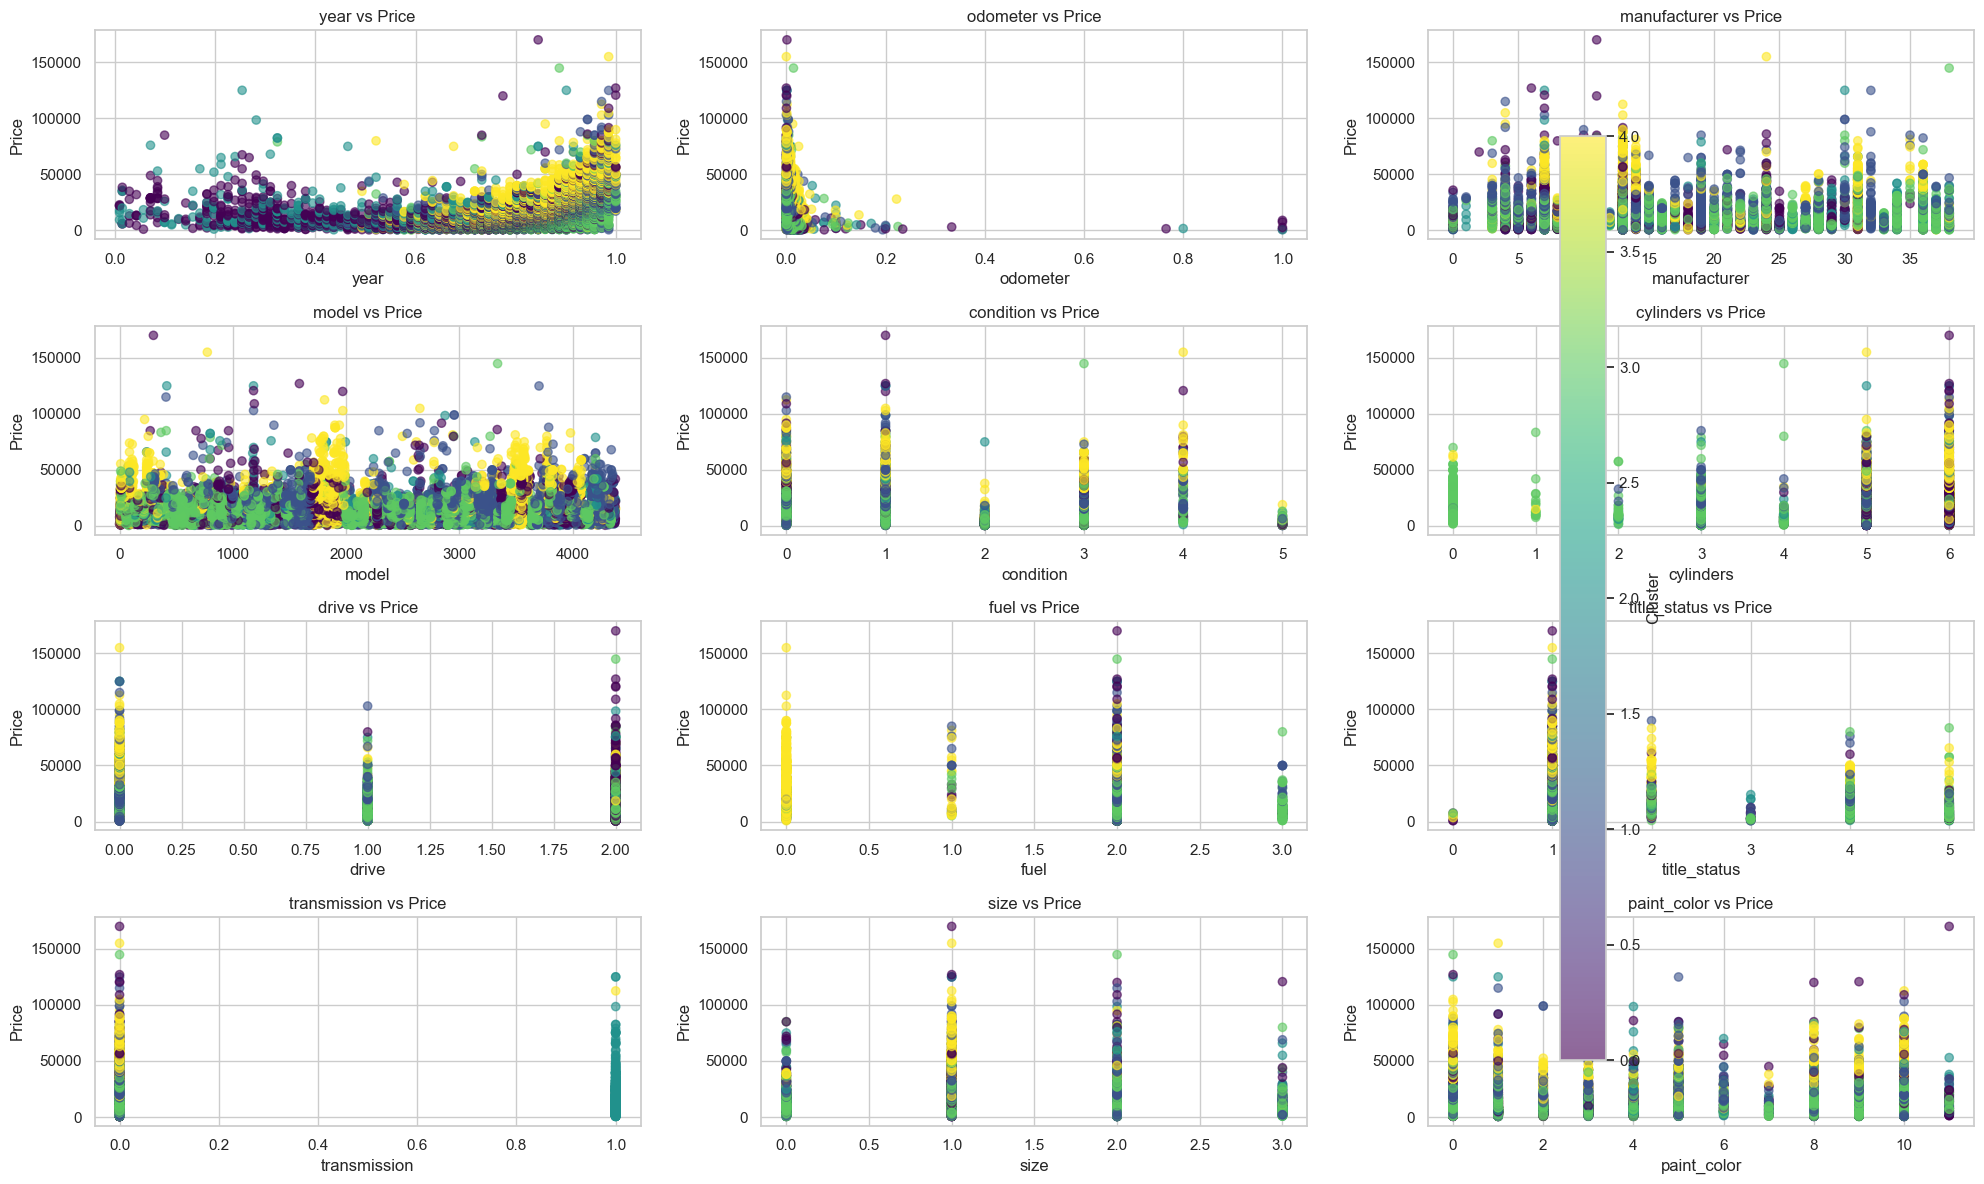


Cluster Statistics:

Cluster 0:
Number of cars: 4270
Average price: $11,880.04
Price range: $550.00 - $169,999.00

Cluster 1:
Number of cars: 4620
Average price: $13,527.84
Price range: $600.00 - $124,900.00

Cluster 2:
Number of cars: 1380
Average price: $12,435.62
Price range: $550.00 - $125,000.00

Cluster 3:
Number of cars: 4831
Average price: $9,811.37
Price range: $500.00 - $144,832.00

Cluster 4:
Number of cars: 3674
Average price: $23,458.61
Price range: $650.00 - $155,000.00


In [238]:
# Load the data
df = pd.read_csv('numerical_data.csv')

# Separate features and target
X = df.drop('price', axis=1)
y = df['price']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-means clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original dataframe
df['Cluster'] = cluster_labels

# Create subplots for each attribute compared to price
attributes = ['year', 'odometer', 'manufacturer', 'model', 'condition', 'cylinders', 'drive', 'fuel', 'title_status', 'transmission', 'size', 'paint_color']
fig, axes = plt.subplots(4, 3, figsize=(20, 12))
axes = axes.ravel()

for idx, attribute in enumerate(attributes):
    scatter = axes[idx].scatter(df[attribute], df['price'], 
                              c=df['Cluster'], 
                              cmap='viridis', 
                              alpha=0.6)
    axes[idx].set_xlabel(attribute)
    axes[idx].set_ylabel('Price')
    axes[idx].set_title(f'{attribute} vs Price')
    
# Add a colorbar
plt.colorbar(scatter, ax=axes, label='Cluster')

plt.tight_layout()
plt.show()

# Print cluster statistics
print("\nCluster Statistics:")
for cluster in range(n_clusters):
    cluster_data = df[df['Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"Number of cars: {len(cluster_data)}")
    print(f"Average price: ${cluster_data['price'].mean():,.2f}")
    print(f"Price range: ${cluster_data['price'].min():,.2f} - ${cluster_data['price'].max():,.2f}")

### 5.0 Train/Test splitting

All the collected data needs to be split to test, train. We will split 20/80 = test/train

In [239]:
#features (X) and target (y)
X = df.drop(columns='price')
y = df['price']
data = pd.read_csv('numerical_data.csv')
# Create DataFrame
df = pd.DataFrame(data, columns=['make', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drivetrain', 'size', 'type', 'paint_color', 'price'])
X = pd.get_dummies(X)

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate MAPE
mape_score = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE Score: {mape_score:.2f}%")

MAPE Score: 0.95%


### XGBoost regressor

In [240]:
"""import xgboost
print(xgboost.__version__)
# Train an XGBoost regressor model
xgb_model = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)
xgb_model.fit(X_train, y_train)"""

"import xgboost\nprint(xgboost.__version__)\n# Train an XGBoost regressor model\nxgb_model = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)\nxgb_model.fit(X_train, y_train)"